In [100]:
import numpy as np
import gurobipy as gp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

import warnings
warnings.filterwarnings("ignore")

gurobi_time_limit = 3600

## Q1

In [101]:
#Reading csv files
stocks_2019 = pd.read_csv('stocks2019.csv')
stocks_2020 = pd.read_csv('stocks2020.csv')

#Dropping rows where all rows are NaN (to remove blank trailing rows - if any)
stocks_2019.dropna(axis=0, how='all',inplace=True)
stocks_2020.dropna(axis=0, how='all',inplace=True)

#Storing these dataframes for future usage
s2019 = stocks_2019.copy()
s2020 = stocks_2020.copy()

#Dropping NDX as it is not a Stock but the NASDAQ index itself
stocks_2019 = stocks_2019.drop('NDX',axis=1)
stocks_2020 = stocks_2020.drop('NDX',axis=1)

#setting date column as index for both 2019 and 2020 datasets
stocks_2019 = stocks_2019.set_index('X') 
stocks_2020 = stocks_2020.set_index('X')

#Computing Daily Returns for every stock in 2019
stocks_2019_shift = stocks_2019.shift(1)

#The first row will not have a return.
stocks_2019_shift=stocks_2019_shift[1:]
stocks_2019=stocks_2019[1:]

#Computing the returns
returns_dataframe = ((stocks_2019-stocks_2019_shift)/stocks_2019_shift)


#Matrix storing daily returns for every stock in 2019
returns_dataframe.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [102]:
# Repeating the same tasks for 2020 data

#Computing Returns for every stock in 2020
stocks_2020_shift = stocks_2020.shift(1)

#The first row will not have a return.
stocks_2020_shift=stocks_2020_shift[1:]
stocks_2020=stocks_2020[1:]

#Copmuting the returns
returns_dataframe_2020 = ((stocks_2020-stocks_2020_shift)/stocks_2020_shift)


#Matrix storing daily returns for every stock in 2020
returns_dataframe_2020.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,-0.017604,...,-0.021369,-0.017207,0.021095,0.009727,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2020-01-06,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,-0.011749,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
2020-01-07,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,0.022751,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005034,0.020414,0.067698,-0.002077,0.022830
2020-01-08,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,0.009032,...,-0.012323,0.019400,0.004626,0.009207,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
2020-01-09,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,0.000000,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493


In [103]:
#Storing Nasdaq index values for performance evaluation
nasdaq_2019 = s2019[['X','NDX']]
nasdaq_2020 = s2020[['X','NDX']]

#setting date column as index
nasdaq_2019 = nasdaq_2019.set_index('X') 
nasdaq_2020 = nasdaq_2020.set_index('X')

#Computing Returns for every stock
nasdaq_2019_shift = nasdaq_2019.shift(1)
nasdaq_2020_shift = nasdaq_2020.shift(1)

#The first row will not have a return.
nasdaq_2019_shift=nasdaq_2019_shift[1:]
nasdaq_2019=nasdaq_2019[1:]
nasdaq_2020_shift=nasdaq_2020_shift[1:]
nasdaq_2020=nasdaq_2020[1:]

#Storing daily returns of Nasdaq Index
nasdaq_returns_dataframe_2019 = ((nasdaq_2019-nasdaq_2019_shift)/nasdaq_2019_shift)
nasdaq_returns_dataframe_2020 = ((nasdaq_2020-nasdaq_2020_shift)/nasdaq_2020_shift)

In [104]:
#creating correlation matrix for 2019 data
corrM = returns_dataframe.corr() 

#Now storing most similar stocks for every stock
highest=[]
i=0
print()
for i in range(corrM.shape[1]):
    highest.append(corrM[corrM.columns.values[i]].idxmax())

corrM

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


In [105]:
#Creating a 100*100 Matrix
temp=np.zeros(corrM.shape[0])
for i in range(corrM.shape[0]):
    for j in range(len(corrM.columns.values)):
        if corrM.columns.values[j]==highest[i]:
            temp[i]=j


X = np.zeros((corrM.shape[0],corrM.shape[1]))
for i in range(corrM.shape[0]):
    for j in range(corrM.shape[1]):
        if j==temp[i]:
            X[i,j]=1

#So, we have created the matrix to store Xij

In [106]:
#Creating an array to store correlation values in flattened form from Matrix
corr_array = np.zeros(corrM.shape[0]*corrM.shape[1])
k=0
for i in range(corrM.shape[0]):
    for j in range(corrM.shape[1]):
        corr_array[k]=corrM.iloc[i,j]
        k=k+1

## Q2

**First we will solve the Integer Programming Problem. There are 100 Yj variables and 100*100 Xij variables for this particular data**

In [107]:
#Initializing Objective Function
obj = np.append(corr_array,([0]*(corrM.shape[0])))

#Initializing Constraint Matrix
A = np.zeros((1+corrM.shape[0]+len(corr_array),corrM.shape[0]+len(corr_array)))


**First Constraint**

In [108]:
A[0,:] = np.append(([0]*len(corr_array)),([1]*(corrM.shape[0])))

k=1

**Second Constraint**

In [109]:
for i in range(X.shape[0]):
    A[k,i*X.shape[0]:(i+1)*X.shape[0]]=1
    k=k+1

**Third Constraint**

In [110]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        A[k,(i*X.shape[0])+j] = 1
        A[k,j+len(corr_array)] = -1
        k=k+1 

In [111]:
sense = np.append(['='],['=']*X.shape[0])
sense = np.append(sense,['<']*(len(A)-1-X.shape[0]))
b = np.append([5],[1]*X.shape[0])
b = np.append(b,[0]*(len(A)-1-X.shape[0]))

In [112]:
#Solving the integer program
lpMod = gp.Model()
lpMod_x = lpMod.addMVar(len(corr_array)+corrM.shape[0],vtype=['B']*(len(corr_array)+corrM.shape[0]))
lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
lpMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
lpMod.optimize()

In [113]:
lpMod_x.x

array([ 0., -0., -0., ..., -0.,  1., -0.])

In [114]:
lpMod.objVal

54.83990652229107

In [115]:
#reshaping matrix for readability and further processing
reshaped_X=lpMod_x.x[:len(corr_array)].reshape(X.shape[0],X.shape[1])
reshaped_y=lpMod_x.x[len(corr_array):]

In [116]:
itemindex = np.where(reshaped_y == 1) #storing index value for selected stocks
list_of_selected_stocks=corrM.index.values[itemindex].tolist()
print("So Selected Stocks are: ",list_of_selected_stocks)


#Storing the returns of only these stocks in a new dataframe
selected_stocks_returns = returns_dataframe[list_of_selected_stocks]
selected_stocks_returns_array = selected_stocks_returns.to_numpy()

#Fetching the returns of the selected stocks for 2020 as well
selected_stocks_returns_2020 = returns_dataframe_2020[list_of_selected_stocks]
selected_stocks_returns_array_2020 = selected_stocks_returns_2020.to_numpy()

So Selected Stocks are:  ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']


In [117]:
#storing no of days for both datasets for further processing
no_of_days_2019 = len(nasdaq_returns_dataframe_2019)
no_of_days_2020 = len(nasdaq_returns_dataframe_2020)

#initializing daily returns for Nasdaq Index for 2019
q=np.array(nasdaq_returns_dataframe_2019['NDX'])

#initializing daily returns for Nasdaq Index for 2020
q_2020=np.array(nasdaq_returns_dataframe_2020['NDX'])

**Now we will formulate a Linear Program to calculate Portfolio Weights**

In [118]:
#Setting objective function
obj = np.append([1]*no_of_days_2019,[0]*len(list_of_selected_stocks))

#initializing constraints matrix
A = np.zeros((2*(no_of_days_2019)+1,no_of_days_2019+len(list_of_selected_stocks)))
k=0

#Setting first constraint: The absolute value one
for i in range(no_of_days_2019):
    A[k,i]= 1
    A[k,no_of_days_2019:] = selected_stocks_returns_array[i]
    k=k+1
    A[k,i]= 1
    A[k,no_of_days_2019:] = -selected_stocks_returns_array[i]
    k=k+1

#Setting second constraint: sum of all weights should be equal to 1    
A[k,:] = np.append([0]*no_of_days_2019,[1]*len(list_of_selected_stocks))

sense = np.append(['>']*(2*no_of_days_2019),['='])

b=np.zeros(len(sense))
k=0
for i in range(no_of_days_2019):
    b[2*i] = q[i]
    k=k+1
    b[2*i+1] = -q[i]
    k=k+1        
b[k] = 1

In [119]:
#Solving Linear Program
lpMod = gp.Model()
lpMod_x = lpMod.addMVar(no_of_days_2019+len(list_of_selected_stocks))
lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
lpMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
lpMod.optimize()

In [120]:
#We are interested in the weights of the stocks. Extracting these weights
weights=lpMod_x.x[no_of_days_2019:]
weights

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

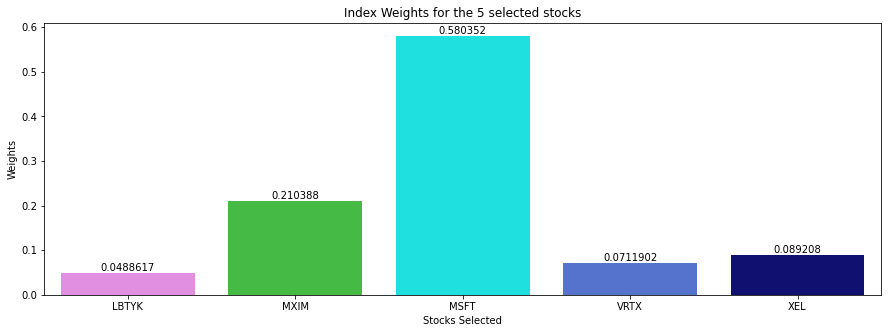

In [121]:
#Plotting weights of selected stocks in portfolio
plt.figure(figsize = (15,5))
plt.title("Index Weights for the 5 selected stocks")
color = ['violet','limegreen','cyan','royalblue','navy']
ax=sn.barplot(x = list_of_selected_stocks , y = weights,palette=color)
plt.ylabel("Weights")
plt.xlabel("Stocks Selected")
for i in ax.containers:
    ax.bar_label(i,)

In [122]:
#Now we will calculate absolute deviation of index fund from NASDAQ for 2019
absolute_deviation_2019 = 0
for i in range(no_of_days_2019):
    wr = 0
    for j in range(len(list_of_selected_stocks)):
        wr = wr + (weights[j]*selected_stocks_returns_array[i][j])       
    s = abs(q[i] - wr) 
    absolute_deviation_2019 = absolute_deviation_2019 + s
    
print ("Absolute Deviation for year 2019 is:", absolute_deviation_2019)

#Now we will calculate absolute deviation of index fund from NASDAQ for 2020
absolute_deviation_2020 = 0
for i in range(no_of_days_2020):
    wr = 0
    for j in range(len(list_of_selected_stocks)):
        wr = wr + (weights[j]*selected_stocks_returns_array_2020[i][j])       
    s = abs(q_2020[i] - wr) 
    absolute_deviation_2020 = absolute_deviation_2020 + s
    
print ("\nAbsolute Deviation for year 2020 is:", absolute_deviation_2020)

Absolute Deviation for year 2019 is: 0.789178282463145

Absolute Deviation for year 2020 is: 0.8696699433741913


<AxesSubplot:title={'center':'Performance Evaluation on m=5'}, xlabel='Year', ylabel='Total Absolute Deviation from NASDAQ Index'>

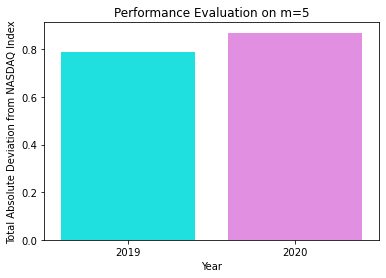

In [123]:
#Now we will plot Performance of the 5-Fund Portfolio for 2019 and 2020. Metric used is Absolute Deviation from Nasdaq
plt.title("Performance Evaluation on m=5")
plt.xlabel("Year")
plt.ylabel("Total Absolute Deviation from NASDAQ Index")
color = ['cyan','violet']
sn.barplot(x = [2019,2020], y = [absolute_deviation_2019,absolute_deviation_2020],palette=color)

Text(0, 0.5, 'Returns')

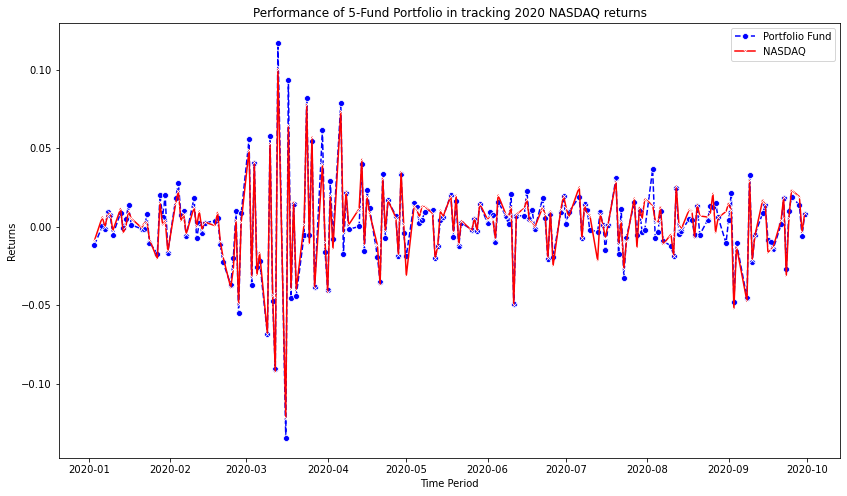

In [124]:
returns_timeline = pd.to_datetime(stocks_2020.index)
weighted_returns = []
#Computing weighted returns
for i in range(no_of_days_2020):
    wr = 0
    for j in range(len(list_of_selected_stocks)):
        wr = wr + (weights[j]*selected_stocks_returns_array_2020[i][j])       
    weighted_returns.append(wr)

plt.figure(figsize = (14,8))

#Plotting weighted returns from 2020 for selected stocks
sn.lineplot(x = returns_timeline, y = np.array(weighted_returns), marker = 'o', 
            linestyle = 'dashed', color = 'blue', label = 'Portfolio Fund')

#Plotting returns from 2020 for NASDAQ
sn.lineplot(x = returns_timeline, y = q_2020, marker = 'x',
             color = 'red', label = 'NASDAQ')

plt.title("Performance of 5-Fund Portfolio in tracking 2020 NASDAQ returns")
plt.xlabel('Time Period')
plt.ylabel('Returns')

As we can see, the 5 fund portfolio does a fairly decent job of tracking the daily returns of NASDAQ in the year 2020

## Q3
Now we will solve Q3

In [125]:
#Initializing lists to store absolute deviation values for 2019 and 2020 for each m value
perf_2019 = [absolute_deviation_2019]
perf_2020 = [absolute_deviation_2020]

#Now we will run the IP and LP as above but inside a loop for different values of m
for m in range(10,110,10):
    if m<=X.shape[0]: #if m is less than or equal to total no of stocks in input file
        print("For m=",m,":\n\n")
        obj = np.append(corr_array,([0]*(corrM.shape[0])))
        A = np.zeros((1+corrM.shape[0]+len(corr_array),corrM.shape[0]+len(corr_array)))
        A[0,:] = np.append(([0]*len(corr_array)),([1]*(corrM.shape[0])))

        k=1

        for i in range(X.shape[0]):
            A[k,i*X.shape[0]:(i+1)*X.shape[0]]=1
            k=k+1

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                A[k,(i*X.shape[0])+j] = 1
                A[k,j+len(corr_array)] = -1
                k=k+1  
        sense = np.append(['='],['=']*X.shape[0])
        sense = np.append(sense,['<']*(len(A)-1-X.shape[0]))
        b = np.append([m],[1]*X.shape[0])
        b = np.append(b,[0]*(len(A)-1-X.shape[0]))

        lpMod = gp.Model()
        lpMod_x = lpMod.addMVar(len(corr_array)+corrM.shape[0],vtype=['B']*(len(corr_array)+corrM.shape[0]))
        lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
        lpMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

        lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        lpMod.optimize()

        reshaped_X=lpMod_x.x[:len(corr_array)].reshape(X.shape[0],X.shape[1]) #reshaping matrix for readability
        reshaped_y=lpMod_x.x[len(corr_array):]

        itemindex = np.where(reshaped_y == 1) #storing index value for selected stocks
        list
        list_of_selected_stocks=corrM.index.values[itemindex].tolist()
        print("So Selected Stocks are: ",list_of_selected_stocks)

        #Storing the returns of only these stocks in a new dataframe for 2019
        selected_stocks_returns = returns_dataframe[list_of_selected_stocks]
        selected_stocks_returns_array = selected_stocks_returns.to_numpy()

        #Storing the returns of only these stocks in a new dataframe for 2020
        selected_stocks_returns_2020 = returns_dataframe_2020[list_of_selected_stocks]
        selected_stocks_returns_array_2020 = selected_stocks_returns_2020.to_numpy()

        no_of_days_2019 = len(nasdaq_returns_dataframe_2019)
        no_of_days_2020 = len(nasdaq_returns_dataframe_2020)

        #initializing returns for Nasdaq (q)
        q=np.array(nasdaq_returns_dataframe_2019['NDX'])

        #for 2020 data
        q_2020=np.array(nasdaq_returns_dataframe_2020['NDX'])

        #Now we will formulate a Linear Program
        obj = np.append([1]*no_of_days_2019,[0]*len(list_of_selected_stocks))
        A = np.zeros((2*(no_of_days_2019)+1,no_of_days_2019+len(list_of_selected_stocks)))
        k=0
        for i in range(no_of_days_2019):
            A[k,i]= 1
            A[k,no_of_days_2019:] = selected_stocks_returns_array[i]
            k=k+1
            A[k,i]= 1
            A[k,no_of_days_2019:] = -selected_stocks_returns_array[i]
            k=k+1
        A[k,:] = np.append([0]*no_of_days_2019,[1]*len(list_of_selected_stocks))

        sense = np.append(['>']*(2*no_of_days_2019),['='])

        b=np.zeros(len(sense))
        k=0
        for i in range(no_of_days_2019):
            b[2*i] = q[i]
            k=k+1
            b[2*i+1] = -q[i]
            k=k+1        
        b[k] = 1

        lpMod = gp.Model()
        lpMod_x = lpMod.addMVar(no_of_days_2019+len(list_of_selected_stocks))
        lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
        lpMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

        lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        lpMod.optimize()

        #We are only interested in the weights of the stocks
        weights=lpMod_x.x[no_of_days_2019:]
        print("Weights of stocks are:",weights)


        #Now we will calculate absolute deviation of index fund from NASDAQ for 2019
        absolute_deviation_2019 = 0
        for i in range(no_of_days_2019):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array[i][j])       
            s = abs(q[i] - wr) 
            absolute_deviation_2019 = absolute_deviation_2019 + s

        print ("\nAbsolute Deviation for year 2019 is:", absolute_deviation_2019)

        #Now we will calculate absolute deviation of index fund from NASDAQ for 2020
        absolute_deviation_2020 = 0
        for i in range(no_of_days_2020):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array_2020[i][j])       
            s = abs(q_2020[i] - wr) 
            absolute_deviation_2020 = absolute_deviation_2020 + s

        perf_2019.append(absolute_deviation_2019)
        perf_2020.append(absolute_deviation_2020)

        print ("\nAbsolute Deviation for year 2020 is:", absolute_deviation_2020)

        print("\n\n\n")



For m= 10 :


So Selected Stocks are:  ['ATVI', 'ALGN', 'BKNG', 'KHC', 'LBTYK', 'MXIM', 'MSFT', 'ROST', 'VRTX', 'XEL']
Weights of stocks are: [0.04113109 0.01220822 0.03947107 0.02150838 0.02807146 0.16324424
 0.48152712 0.08980658 0.05700025 0.06603159]

Absolute Deviation for year 2019 is: 0.6865330111458107

Absolute Deviation for year 2020 is: 0.8313165184500475




For m= 20 :


So Selected Stocks are:  ['ATVI', 'ALGN', 'GOOGL', 'ANSS', 'ADP', 'BIIB', 'BKNG', 'CMCSA', 'DLTR', 'JD', 'KHC', 'LBTYK', 'MXIM', 'MSFT', 'MRNA', 'PCAR', 'PDD', 'ULTA', 'VRTX', 'XEL']
Weights of stocks are: [0.01739277 0.02153427 0.18600136 0.06718136 0.03085371 0.00653493
 0.03024358 0.04730223 0.02007678 0.04482793 0.02686198 0.00691822
 0.11389751 0.2578934  0.00362052 0.03623552 0.01109768 0.00955687
 0.02311798 0.03885141]

Absolute Deviation for year 2019 is: 0.47373603379845963

Absolute Deviation for year 2020 is: 0.6825726084782863




For m= 30 :


So Selected Stocks are:  ['ATVI', 'ADBE', 'GOOGL'

So Selected Stocks are:  ['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOG', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 'EA', 'EXC', 'EXPE', 'FB', 'FAST', 'FISV', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KHC', 'LBTYK', 'LULU', 'MAR', 'MELI', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TCOM', 'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'WDC', 'XEL', 'XLNX']
Weights of stocks are: [3.44079881e-03 2.00146286e-02 4.60909742e-03 3.64782086e-03
 2.31383884e-05 8.41842932e-02 9.44329990e-02 1.41694474e-02
 0.00000000e+00 1.01904960e-01 1.20230295e-02 3.13718570e-03
 4.04475451e-03 1.53011720e-02 5.55183781e-03 7.08950563e-03
 3.80

In [126]:
#Creating a dataframe to store Total Absolute Deviations with NASDAQ for different portfolios for both 2019 and 2020
performance_df_IP = pd.DataFrame(data=[np.append(np.array([5]),np.array(range(10,110,10))),perf_2019, perf_2020]).T
performance_df_IP.rename(columns={0: 'm', 1: 'Performance on 2019 Data', 2: 'Performance on 2020 Data'}, inplace=True)
performance_df_IP=performance_df_IP.set_index('m')
print("Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:\n")

performance_df_IP.dropna(axis=0,how='all',inplace=True) #removing any NaN rows in case no. of stocks in file is <100
performance_df_IP

Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:



,Performance on 2019 Data,Performance on 2020 Data
m,,
5.0,0.789178,0.869670
10.0,0.686533,0.831317
20.0,0.473736,0.682573
30.0,0.418015,0.549085
40.0,0.370517,0.587312
50.0,0.332540,0.581148
60.0,0.344890,0.819424
70.0,0.169824,0.402497
80.0,0.147683,0.386431


Text(0, 0.5, 'Total Absolute Deviation')

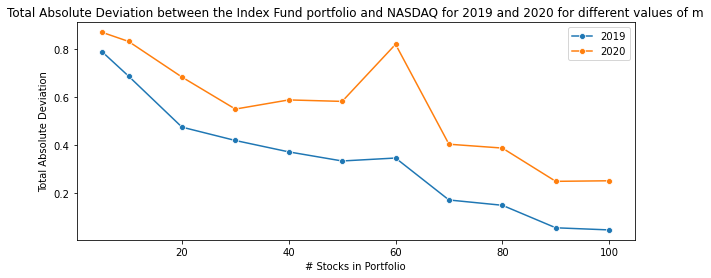

In [127]:
#Converting list to numpy array
perf_2019 = np.array(perf_2019)
perf_2020 = np.array(perf_2020)

#Now we will plot the Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m
plt.figure(figsize = (10,4))
sn.lineplot(x = performance_df_IP.index.values, y= perf_2019, label = "2019", marker = "o")
sn.lineplot(x = performance_df_IP.index.values, y= perf_2020, label = "2020", marker = "o" )
plt.title("Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m")
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")

## Q4
Now we will reformulate this problem as an MIP 

In [128]:
sizes=np.append([5],range(10,110,10))
M=1 #Big M Value
perf_2019 = []
perf_2020 = []

#Creating a pandas dataframe so that we can output it as a CSV file
output_file=pd.DataFrame(pd.DataFrame(columns = ['m', 'Stocks Selected', 'Weights','Absolute Deviation 2019','Absolute Deviation 2020']))

for m in sizes:
    if m<=X.shape[0]: #if m is less than the no. of total stocks in file
        print("\n\nFor m=",m)

        obj = np.append([1]*no_of_days_2019,[0]*X.shape[0])
        obj= np.append(obj,[0]*X.shape[0])
        A = np.zeros((2*(no_of_days_2019)+2+(X.shape[0]),no_of_days_2019+(2*X.shape[0])))
        k=0
        for i in range(no_of_days_2019):
            A[k,i]= 1
            A[k,no_of_days_2019:no_of_days_2019+X.shape[0]] = np.array(returns_dataframe.iloc[i])
            k=k+1
            A[k,i]= 1
            A[k,no_of_days_2019:no_of_days_2019+X.shape[0]] = -np.array(returns_dataframe.iloc[i])
            k=k+1


        A[k,no_of_days_2019:no_of_days_2019+X.shape[0]] = np.array([1]*X.shape[0])

        k=k+1

        for i in range(X.shape[0]):
            A[k,no_of_days_2019+i] = 1
            A[k,no_of_days_2019+X.shape[0]+i] = -M
            k=k+1

        A[k,no_of_days_2019+X.shape[0]:] = 1

        sense = np.append(['>']*(2*no_of_days_2019),['='])
        sense = np.append(sense,['<']*X.shape[0])
        sense = np.append(sense,['='])

        b=np.zeros(len(sense))
        k=0
        for i in range(no_of_days_2019):
            b[2*i] = q[i]
            k=k+1
            b[2*i+1] = -q[i]
            k=k+1        
        b[k] = 1
        k=k+1

        for i in range(X.shape[0]):
            b[k] = 0
            k=k+1

        b[k] = m

        vtype = ['C']*(no_of_days_2019+(X.shape[0])) + ['B']*X.shape[0]

        lpMod = gp.Model()
        lpMod_x = lpMod.addMVar(no_of_days_2019+(2*X.shape[0]),vtype=vtype)
        lpMod_con = lpMod.addMConstrs(A, lpMod_x, sense, b)
        lpMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

        lpMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
        lpMod.setParam('TimeLimit', gurobi_time_limit) #Setting 1 hour time limit
        lpMod.optimize()

        #Storing the weights of the stocks
        weights=lpMod_x.x[no_of_days_2019:no_of_days_2019+X.shape[0]]

        #Storing the Yi values (whether a stock is selected or not)
        y = lpMod_x.x[no_of_days_2019+X.shape[0]:]

        itemindex = np.where(y == 1) #storing index value for selected stocks
        list_of_selected_stocks=corrM.index.values[itemindex].tolist()
        print("So Selected Stocks are: ",list_of_selected_stocks)
        weights = weights[itemindex]
        print("\nWeights are:",weights)

        #Storing the returns of only these stocks in a new dataframe
        selected_stocks_returns = returns_dataframe[list_of_selected_stocks]
        selected_stocks_returns_array = selected_stocks_returns.to_numpy()

        #Storing the returns of only these stocks in a new dataframe for 2020
        selected_stocks_returns_2020 = returns_dataframe_2020[list_of_selected_stocks]
        selected_stocks_returns_array_2020 = selected_stocks_returns_2020.to_numpy()

        #Now we will calculate absolute deviation of index fund from NASDAQ for 2019
        absolute_deviation_2019 = 0
        for i in range(no_of_days_2019):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array[i][j])       
            s = abs(q[i] - wr) 
            absolute_deviation_2019 = absolute_deviation_2019 + s

        print ("Absolute Deviation for year 2019 is:", absolute_deviation_2019)

        #Now we will calculate absolute deviation of index fund from NASDAQ for 2020
        absolute_deviation_2020 = 0
        for i in range(no_of_days_2020):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array_2020[i][j])       
            s = abs(q_2020[i] - wr) 
            absolute_deviation_2020 = absolute_deviation_2020 + s

        print ("\nAbsolute Deviation for year 2020 is:", absolute_deviation_2020)

        perf_2019.append(absolute_deviation_2019)
        perf_2020.append(absolute_deviation_2020)

        output_file = output_file.append({'m' : m, 'Stocks Selected' : list_of_selected_stocks, 'Weights' : weights,'Absolute Deviation 2019':absolute_deviation_2019,'Absolute Deviation 2020':absolute_deviation_2020},ignore_index = True)



For m= 5
So Selected Stocks are:  ['AMZN', 'ADI', 'AAPL', 'MSFT', 'MDLZ']

Weights are: [0.2501226  0.11375807 0.19169221 0.28986928 0.15455784]
Absolute Deviation for year 2019 is: 0.4992586920546348

Absolute Deviation for year 2020 is: 0.5913979244173758


For m= 10
So Selected Stocks are:  ['GOOG', 'AMZN', 'AAPL', 'CSCO', 'FB', 'GILD', 'MXIM', 'MSFT', 'VRSK', 'XLNX']

Weights are: [0.10203308 0.11944128 0.14107239 0.06185098 0.09199241 0.07419829
 0.04984952 0.19964997 0.11818319 0.04172889]
Absolute Deviation for year 2019 is: 0.3037415482998673

Absolute Deviation for year 2020 is: 0.5157012572969307


For m= 20
So Selected Stocks are:  ['ADBE', 'GOOG', 'AMZN', 'AMGN', 'AAPL', 'AVGO', 'CSCO', 'CTXS', 'FB', 'INTC', 'MU', 'MSFT', 'NFLX', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'REGN', 'TXN', 'WBA']

Weights are: [0.02686893 0.09401859 0.10434717 0.03118629 0.11319151 0.02559751
 0.03848835 0.03570279 0.05675279 0.03550502 0.02055133 0.116614
 0.02480457 0.03107371 0.06919443 0.024275   0.

So Selected Stocks are:  ['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOGL', 'GOOG', 'AMZN', 'AMGN', 'AAPL', 'AMAT', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'COST', 'CSX', 'DXCM', 'DLTR', 'EBAY', 'EA', 'EXC', 'EXPE', 'FB', 'FAST', 'FISV', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KLAC', 'KHC', 'LRCX', 'LBTYK', 'LULU', 'MAR', 'MXIM', 'MELI', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SWKS', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN', 'TCOM', 'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX']

Weights are: [4.22328959e-03 1.71400493e-02 4.03700187e-03 2.44975218e-03
 5.68288393e-02 2.97166204e-02 9.56134145e-02 1.36372497e-02
 1.02011397e-01 3.55226480e-03 1.35311414e-03 3.92298038e-03
 1.47585757e-02 5.12995688e-03 6.65961040e-03 3.96161154e-03
 1.13472897e

In [129]:
#Writing output file
output_file.to_csv('output_bigM.csv')

In [130]:
performance_df = pd.DataFrame(data=[sizes,perf_2019, perf_2020]).T
performance_df.rename(columns={0: 'm', 1: 'Performance on 2019 Data', 2: 'Performance on 2020 Data'}, inplace=True)
performance_df=performance_df.set_index('m')
print("Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:\n")

performance_df.dropna(axis=0,how='all',inplace=True) #removing rows with all Nan - this happens if no. of stocks in unput file <100
performance_df

Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:



,Performance on 2019 Data,Performance on 2020 Data
m,,
5.0,0.499259,0.591398
10.0,0.303742,0.515701
20.0,0.166831,0.411898
30.0,0.108638,0.334916
40.0,0.079863,0.304620
50.0,0.062373,0.260249
60.0,0.052054,0.247994
70.0,0.047690,0.250920
80.0,0.045227,0.249124


Text(0, 0.5, 'Total Absolute Deviation')

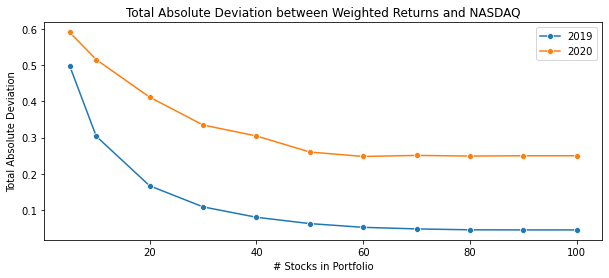

In [131]:
perf_2019 = np.array(perf_2019)
perf_2020 = np.array(perf_2020)

plt.figure(figsize = (10,4))
sn.lineplot(x = performance_df.index.values, y= perf_2019, label = "2019", marker = "o")
sn.lineplot(x = performance_df.index.values, y= perf_2020, label = "2020", marker = "o" )
plt.title("Total Absolute Deviation between Weighted Returns and NASDAQ")
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")

So clearly at around m=60, the performance stabilizes and adding additional stocks does not improve performance by much. But while utilizing the first method, we saw the the performance keeps on increasing with the addition of more stocks. Also, the magnitude of deviations is smaller in the second method compared to the first. So, the second method yields a better and more stable performance. However, it is computationally far more expensive.

So, around m=60 seems to be the optimal selection. 

In [164]:
#Importing csv so that we dont have to run 10 hour code again.

results = pd.read_csv('output_bigM.csv')
results=results.drop('Unnamed: 0',axis=1)
results=results.set_index('m')

#Fetching weights and stocks for m=60
best_model = results[results.index==60]
stocks_selected_best_model = best_model['Stocks Selected'].iloc[0]
weights_best_model = best_model['Weights'].iloc[0]

#Processing data so that it can be converted into python friendly format
stocks_selected_best_model=stocks_selected_best_model.lstrip('[').rstrip(']')
stocks_selected_best_model=stocks_selected_best_model.replace("'","")
stocks_selected_best_model=stocks_selected_best_model.split(",")

weights_best_model=weights_best_model.lstrip('[').rstrip(']')
weights_best_model=weights_best_model.replace("\n","")
weights_best_model
weights_best_model=weights_best_model.split(" ")
weights_best_model
for i in range(len(weights_best_model)):
    if weights_best_model[i]=='':
        weights_best_model[i]=111111
    else:    
        weights_best_model[i] = float(weights_best_model[i])
weights_best_model=[i for i in weights_best_model if i!=111111]

#Storing names of selected stocks
for i in range(len(stocks_selected_best_model)):
    stocks_selected_best_model[i]=stocks_selected_best_model[i].replace(" ","")

#calculating weighted returns for portfolio
selected_stocks_returns_2020 = returns_dataframe_2020.filter(items = stocks_selected_best_model,axis=1)
weighted_returns_best_model = np.zeros(len(selected_stocks_returns_2020))
for i in range(len(selected_stocks_returns_2020)):
    for j in range(len(stocks_selected_best_model)):
        weighted_returns_best_model[i] += weights_best_model[j]*selected_stocks_returns_2020.iloc[i,j]
        


Text(0, 0.5, 'Returns')

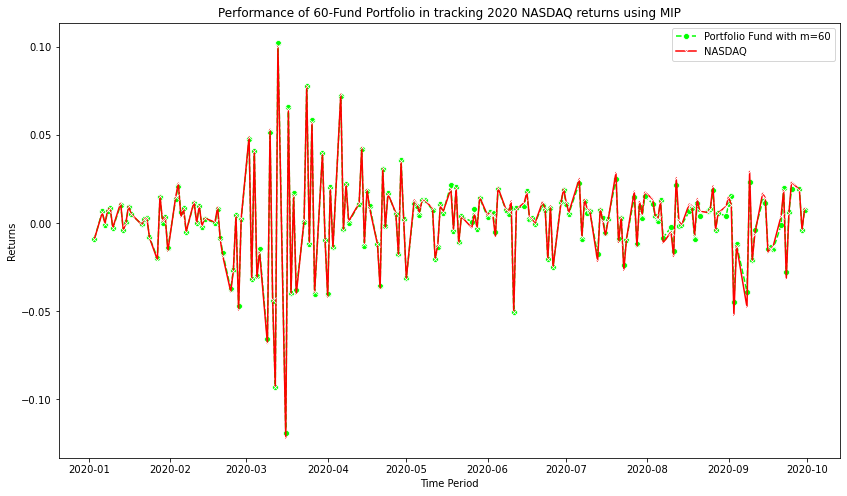

In [165]:
returns_timeline1 = pd.to_datetime(stocks_2020.index)

plt.figure(figsize = (14,8))

#Plotting weighted returns from 2020 for selected stocks
sn.lineplot(x = returns_timeline, y = np.array(weighted_returns_best_model), marker = 'o', 
            linestyle = 'dashed', color = 'lime', label = 'Portfolio Fund with m=60')

#Plotting returns from 2020 for NASDAQ
sn.lineplot(x = returns_timeline, y = q_2020, marker = 'x',
             color = 'red', label = 'NASDAQ')

plt.title("Performance of 60-Fund Portfolio in tracking 2020 NASDAQ returns using MIP")
plt.xlabel('Time Period')
plt.ylabel('Returns')

So, we can clearly see from the above plot that using the MIP method, the 60-fund portfolio is doing an excellent job of tracking the NASDAQ Index in 2020 (unssen data).